In [6]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader, BatchSampler, RandomSampler
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
pprint = lambda st : print(st.expandtabs(32))

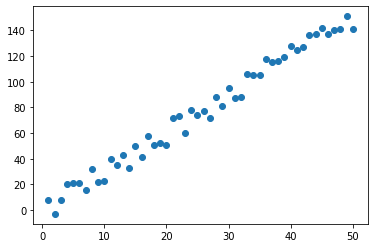

In [4]:
x = torch.linspace(1, 50, 50).reshape(-1, 1)
e = torch.randint(-10, 10, (50, 1), dtype=torch.float)
y = 3 * x + 1 + e

plt.scatter(x.numpy(), y.numpy())

In [7]:
class Model(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
    
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

torch.manual_seed(59)

model = Model(1, 1)

print('initial values ')
for name, param in model.named_parameters():
    print(f'\t {name} \t {param.item()}')

initial values 
	 linear.weight 	 0.10597813129425049
	 linear.bias 	 0.9637961387634277


epoch 0
	loss: 7214.5263671875 weight: 0.6025182604789734 bias: 0.9784868955612183
epoch 1
	loss: 4958.884765625 weight: 1.0137275457382202 bias: 0.9906423687934875
epoch 2
	loss: 3411.8974609375 weight: 1.3542702198028564 bias: 1.000698208808899
epoch 3
	loss: 2350.927490234375 weight: 1.636290431022644 bias: 1.0090153217315674
epoch 4
	loss: 1623.282470703125 weight: 1.8698453903198242 bias: 1.0158923864364624
epoch 5
	loss: 1124.2418212890625 weight: 2.0632638931274414 bias: 1.021577000617981
epoch 6
	loss: 781.984619140625 weight: 2.2234435081481934 bias: 1.0262740850448608
epoch 7
	loss: 547.25439453125 weight: 2.3560962677001953 bias: 1.0301532745361328
epoch 8
	loss: 386.26953125 weight: 2.4659526348114014 bias: 1.0333551168441772
epoch 9
	loss: 275.86126708984375 weight: 2.5569305419921875 bias: 1.0359960794448853
epoch 10
	loss: 200.13983154296875 weight: 2.6322739124298096 bias: 1.0381724834442139
epoch 11
	loss: 148.20799255371094 weight: 2.694669723510742 bias: 1.0399641990

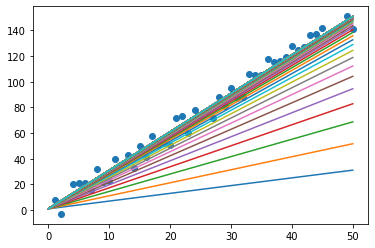

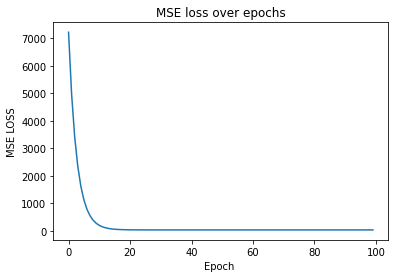

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
def predict(epochs):
    losses = []
    plt.scatter(x.numpy(), y.numpy())
    for i in range(epochs):
        y_pred = model.forward(x)
        loss = criterion(y_pred, y)
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        f = np.poly1d([model.linear.weight.item(), model.linear.bias.item()])
        plt.plot([0,50], f([0, 50]), '-')
        print(f'epoch {i}')
        print(f'\tloss: {loss.item()} weight: {model.linear.weight.item()} bias: {model.linear.bias.item()}')

    plt.show()

    plt.plot(range(epochs), losses)
    plt.title('MSE loss over epochs')
    plt.ylabel('MSE LOSS')
    plt.xlabel('Epoch ')
    plt.show()

predict(100)

In [11]:
class StaticDataset(Dataset):      # Same input size
    def __len__(self):
        return 10
    
    def __getitem__(self, idx):
        return (torch.tensor([idx, 2*idx, 3*idx], dtype=torch.float32), torch.tensor(idx, dtype=torch.float32))

class VariableDataset(Dataset):   # Variable input size
    def __len__(self):
        return 10
    
    def __getitem__(self, idx):
        return (torch.tensor([idx] * (idx+1), dtype=torch.float32),  torch.tensor(idx, dtype=torch.float32))

static_dataset = StaticDataset()
var_dataset = VariableDataset()

In [43]:
name2sampler = {
    "No_sampler" : None,
    "RandomSampler" : RandomSampler(static_dataset),
    "BatchSampler" : BatchSampler(RandomSampler(static_dataset), 3, False)
}
static_dl = torch.utils.data.DataLoader(static_dataset, batch_size=3)

for name, sampler in name2sampler.items():
    if name == "BatchSampler":
        static_dl = torch.utils.data.DataLoader(static_dataset, batch_sampler=sampler)
    else:
        static_dl = torch.utils.data.DataLoader(static_dataset, batch_size=3, sampler=sampler)
    pprint(f"Static data with {name}")
    for X, y in static_dl:
         print(f"\t {X.tolist()} {y}")

def make_batch(samples):
    X = [sample[0] for sample in samples]
    y = [sample[1] for sample in samples]
    X = torch.nn.utils.rnn.pad_sequence(X, batch_first=True)
    return X, torch.stack(y)    # list of tensor -> tensor of list
    
var_dl = torch.utils.data.DataLoader(var_dataset, batch_size=3, collate_fn=make_batch)

print(f"Variable data with No_sampler")
for X, y in var_dl:
    print(f"\t{X.tolist()} {y}")

Static data with No_sampler
	 [[0.0, 0.0, 0.0], [1.0, 2.0, 3.0], [2.0, 4.0, 6.0]] tensor([0., 1., 2.])
	 [[3.0, 6.0, 9.0], [4.0, 8.0, 12.0], [5.0, 10.0, 15.0]] tensor([3., 4., 5.])
	 [[6.0, 12.0, 18.0], [7.0, 14.0, 21.0], [8.0, 16.0, 24.0]] tensor([6., 7., 8.])
	 [[9.0, 18.0, 27.0]] tensor([9.])
Static data with RandomSampler
	 [[4.0, 8.0, 12.0], [7.0, 14.0, 21.0], [3.0, 6.0, 9.0]] tensor([4., 7., 3.])
	 [[2.0, 4.0, 6.0], [5.0, 10.0, 15.0], [0.0, 0.0, 0.0]] tensor([2., 5., 0.])
	 [[9.0, 18.0, 27.0], [8.0, 16.0, 24.0], [1.0, 2.0, 3.0]] tensor([9., 8., 1.])
	 [[6.0, 12.0, 18.0]] tensor([6.])
Static data with BatchSampler
	 [[3.0, 6.0, 9.0], [7.0, 14.0, 21.0], [2.0, 4.0, 6.0]] tensor([3., 7., 2.])
	 [[5.0, 10.0, 15.0], [0.0, 0.0, 0.0], [4.0, 8.0, 12.0]] tensor([5., 0., 4.])
	 [[9.0, 18.0, 27.0], [1.0, 2.0, 3.0], [6.0, 12.0, 18.0]] tensor([9., 1., 6.])
	 [[8.0, 16.0, 24.0]] tensor([8.])
Variable data with No_sampler
	[[0.0, 0.0, 0.0], [1.0, 1.0, 0.0], [2.0, 2.0, 2.0]] tensor([0., 1., 2.])


In [18]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

pprint(f'Image name \t {img_name}')
pprint(f'Landmarks shape \t {landmarks.shape}')
pprint(f'First 2 Landmarks \t {landmarks[:2].tolist()}')


Image name                       person-7.jpg
Landmarks shape                  (68, 2)
First 2 Landmarks                [[32.0, 65.0], [33.0, 76.0]]


In [25]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_path, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_path)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks]).astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}


0 (324, 215, 3) (68, 2)


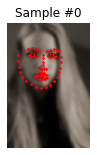

1 (500, 333, 3) (68, 2)


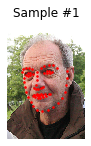

2 (250, 258, 3) (68, 2)


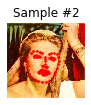

3 (434, 290, 3) (68, 2)


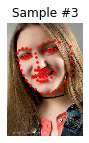

In [26]:
face_dataset = FaceLandmarksDataset(csv_path='data/faces/face_landmarks.csv', root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break


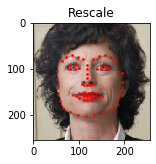

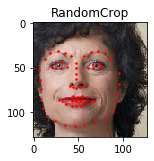

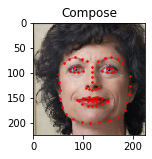

In [28]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [30]:
transformed_dataset = FaceLandmarksDataset('data/faces/face_landmarks.csv', 'data/faces/',
                                transforms.Compose([Rescale(256), RandomCrop(224), ToTensor()]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break


0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


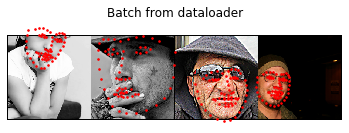

In [31]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break